In [1]:
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython

c:\Users\dorasir\anaconda3\envs\net-simu\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [2]:
import numpy as np
import os
from sklearn.metrics import average_precision_score, roc_auc_score
import pandas as pd
from utils.transformation import clr_transform, alr_transform
from matplotlib import pyplot as plt
from itertools import product
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from utils import simulation
import rpy2.robjects as robjects
import seaborn as sns
from utils.generalized_lotka_volterra import GeneralizedLotkaVolterra
from utils.compositional_lotka_volterra import CompositionalLotkaVolterra
from scipy.stats import ttest_rel


os.chdir('d:\\microbial_network\\microbial_network_explore')

In [3]:
n_vertices = 50
avg_degree = 5

time_points = 100
time_step = 0.01
downsample = 1
noise_var = 1e-3
scale_simulation = 100

# No noise simulation

In [4]:
network_type = 'random'
# network_type = 'small-world'

interaction_type = 'random'

adj, M = simulation.gen_graph(n_vertices, avg_degree, network_type=network_type, interaction_type=interaction_type)

In [9]:
vs = [25, 50, 100]
ds = [2, 5, 10]
ns = ['random', 'small-world', 'scale-free']

In [8]:
# score_df = pd.DataFrame(columns=['vertices', 'degree', 'type', 'mean', 'std'])
scores = []
for v, d, n in tqdm(product(vs, ds, ns)):
    adj, M = simulation.gen_graph(v, d, network_type=n, interaction_type='random')
    baseline_scores = []
    repeat = 100
    for _ in range(repeat):
        baseline = np.mean(np.dstack([np.random.uniform(0, 1, size=(v, v)) for _ in range(repeat)]), axis=2)
        baseline_score = average_precision_score(adj[~np.eye(v, dtype=bool)], baseline[~np.eye(v, dtype=bool)])
        baseline_scores.append(baseline_score)
    mu = np.mean(baseline_scores)
    sigma = np.std(baseline_scores)
    scores.append([v, d, n, mu, sigma])
score_df = pd.DataFrame(scores, columns=['vertices', 'degree', 'type', 'mean', 'std'])


27it [00:20,  1.29it/s]


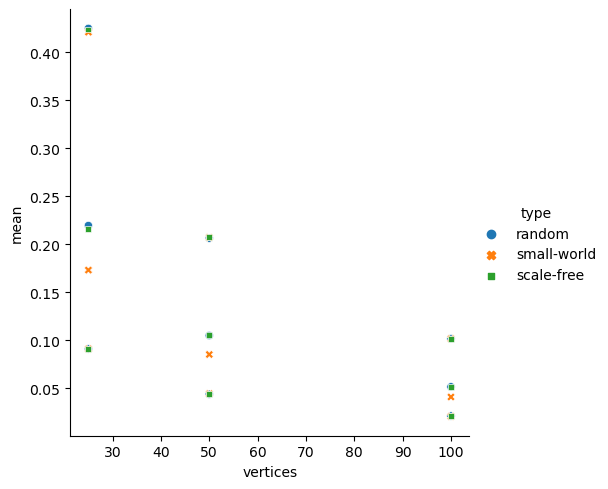

In [16]:
sns.relplot(x='vertices', y='mean', data=score_df, hue='type', style='type')

PRAUC: 0.105 +- 0.007
AUROC: 0.500 +- 0.020


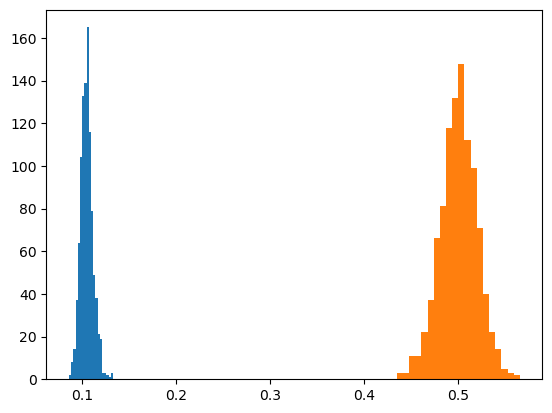

In [7]:
baseline_pr = []
baseline_auc = []
repeat = 1000
for _ in range(repeat):
    # baseline = np.mean(np.dstack([np.random.uniform(0, 1, size=(n_vertices, n_vertices)) for _ in range(repeat)]), axis=2)
    # baseline_score = average_precision_score(adj[~np.eye(n_vertices, dtype=bool)], baseline[~np.eye(n_vertices, dtype=bool)])
    # baseline_scores.append(baseline_score)
    baseline = np.random.uniform(0, 1, size=(n_vertices, n_vertices))
    baseline_pr.append(average_precision_score(adj[~np.eye(n_vertices, dtype=bool)], baseline[~np.eye(n_vertices, dtype=bool)]))
    baseline_auc.append(roc_auc_score(adj[~np.eye(n_vertices, dtype=bool)], baseline[~np.eye(n_vertices, dtype=bool)]))
n, bins, _ = plt.hist(baseline_pr, bins=20)
mu = np.mean(baseline_pr)
sigma = np.std(baseline_pr)
print(f'PRAUC: {mu:.3f} +- {sigma:.3f}')

n, bins, _ = plt.hist(baseline_auc, bins=20)
mu = np.mean(baseline_auc)
sigma = np.std(baseline_auc)
print(f'AUROC: {mu:.3f} +- {sigma:.3f}')

## Simulation result on single simulation

In [5]:
import utils.evaluations as ev
metrics = [average_precision_score, roc_auc_score]

In [8]:
# Simulate data
abd, _, _ = simulation.simulate_noiseless_glv(time_points=time_points, downsample=downsample, adj=adj, M=M)
abd_df = pd.DataFrame(abd)

In [14]:
ev.correlation_score(abd_df, adj, metrics=metrics, verbose=True)
ev.precision_matrix_score(abd_df, adj, metrics=metrics, verbose=True)

average_precision_score: 0.3020948197308429
roc_auc_score: 0.43979636363636365
average_precision_score: 0.18997026883803111
roc_auc_score: 0.5033236363636363


[0.18997026883803111, 0.5033236363636363]

In [15]:
abd_clr = pd.DataFrame(clr_transform(abd_df))

ev.correlation_score(abd_clr, adj, metrics=metrics, verbose=True)
ev.precision_matrix_score(abd_clr, adj, metrics=metrics, verbose=True)

average_precision_score: 0.13247471028003166
roc_auc_score: 0.43224000000000007
average_precision_score: 0.09527963823992544
roc_auc_score: 0.4669236363636364


[0.09527963823992544, 0.4669236363636364]

In [23]:
ev.clv_score(abd, adj, metrics=metrics, verbose=True)
ev.glv_score(abd, adj, metrics=metrics, verbose=True)

5722.090562949743
average_precision_score: 0.11865503044946406
roc_auc_score: 0.5346242977463562
average_precision_score: 0.13892878863945846
roc_auc_score: 0.53726


[0.13892878863945846, 0.53726]

In [21]:
%%R -i abd_df -i abd
library(ppcor)
library(SpiecEasi)
network_pred_ppea <- abs(pcor(abd)$estimate)
network_pred_sparcc <- abs(sparcc(abd)$Cor)
network_pred_spiec <- spiec.easi(abd,method='mb')
network_pred_spiec <- as.matrix(getOptMerge(network_pred_spiec))

R[write to console]: Applying data transformations...

R[write to console]: Selecting model with pulsar using stars...

R[write to console]: Fitting final estimate with mb...

R[write to console]: done



In [23]:
print('Partial Pearson')
network_pred_ppea = robjects.globalenv['network_pred_ppea']
network_pred_ppea = np.array(network_pred_ppea)
ev.calc_nondiag_score(network_pred_ppea, adj, metrics=metrics, verbose=True)

print('SparCC')
network_pred_sparcc = robjects.globalenv['network_pred_sparcc']
network_pred_sparcc = np.array(network_pred_sparcc)
ev.calc_nondiag_score(network_pred_sparcc, adj, metrics=metrics, verbose=True)

print('SpiecEasi')
network_pred_spiec = robjects.globalenv['network_pred_spiec']
network_pred_spiec = np.array(network_pred_spiec)
ev.calc_nondiag_score(network_pred_spiec, adj, metrics=metrics, verbose=True)

Partial Pearson
average_precision_score: 0.10126341131477266
roc_auc_score: 0.4984945454545455
SparCC
average_precision_score: 0.12137298576718401
roc_auc_score: 0.5482109090909091
SpiecEasi
average_precision_score: 0.10204081632653061
roc_auc_score: 0.4990909090909091


[0.10204081632653061, 0.4990909090909091]

# Simulation with noise using MiSDEED

In [9]:

abd_df = pd.DataFrame(abd)
abd_clr = pd.DataFrame(clr_transform(abd))

Node 'mgx' initialized
Interaction 'mgx->mgx' added
set m:(mgx)->(mgx):   0:50    0:50
Added x0 vector to node mgx
Added growth rates to node mgx
Initialized
Interaction 'mgx_mgx' added


In [15]:
pearson_scores = ev.correlation_score(abd_df, adj, metrics=metrics, verbose=True)
precision_scores = ev.precision_matrix_score(abd_df, adj, metrics=metrics, verbose=True)
clr_pearson_scores = ev.correlation_score(abd_clr, adj, metrics=metrics, verbose=True)
clr_precision_scores = ev.precision_matrix_score(abd_clr, adj, metrics=metrics, verbose=True)
clv_scores = ev.clv_score(abd, adj, metrics=metrics, verbose=True)
glv_scores = ev.glv_score(abd, adj, metrics=metrics, verbose=True)

average_precision_score: 0.10189989009890035
roc_auc_score: 0.486
average_precision_score: 0.10523239335843781
roc_auc_score: 0.4946890909090909
average_precision_score: 0.10245377727791187
roc_auc_score: 0.5016872727272728
average_precision_score: 0.10208287385423792
roc_auc_score: 0.4989290909090909
4.345180736778373
average_precision_score: 0.10244387817833617
roc_auc_score: 0.5047079634350005
average_precision_score: 0.10380816594799058
roc_auc_score: 0.4865581818181818


In [17]:
%%R -i abd_df -i abd
library(ppcor)
library(SpiecEasi)
network_pred_ppea <- abs(pcor(abd_df)$estimate)
network_pred_sparcc <- abs(sparcc(abd)$Cor)
network_pred_spiec <- spiec.easi(abd,method='mb')
network_pred_spiec <- as.matrix(getOptMerge(network_pred_spiec))

R[write to console]: 载入需要的程辑包：MASS

R[write to console]: 
载入程辑包：'SpiecEasi'


R[write to console]: The following object is masked from 'package:MASS':

    fitdistr


R[write to console]: Applying data transformations...

R[write to console]: Selecting model with pulsar using stars...

R[write to console]: Fitting final estimate with mb...

R[write to console]: done



In [18]:
print('Partial Pearson')
network_pred_ppea = robjects.globalenv['network_pred_ppea']
network_pred_ppea = np.array(network_pred_ppea)
ev.calc_nondiag_score(network_pred_ppea, adj, metrics=metrics, verbose=True)

print('SparCC')
network_pred_sparcc = robjects.globalenv['network_pred_sparcc']
network_pred_sparcc = np.array(network_pred_sparcc)
ev.calc_nondiag_score(network_pred_sparcc, adj, metrics=metrics, verbose=True)

print('SpiecEasi')
network_pred_spiec = robjects.globalenv['network_pred_spiec']
network_pred_spiec = np.array(network_pred_spiec)
ev.calc_nondiag_score(network_pred_spiec, adj, metrics=metrics, verbose=True)

Partial Pearson
average_precision_score: 0.10126341131477266
roc_auc_score: 0.4984945454545455
SparCC
average_precision_score: 0.10191808017185519
roc_auc_score: 0.47928000000000004
SpiecEasi
average_precision_score: 0.10204081632653061
roc_auc_score: 0.4990909090909091


[0.10204081632653061, 0.4990909090909091]

In [19]:
%%R -i abd
network_pred_spiec <- spiec.easi(abd,method='glasso')
network_pred_spiec <- as.matrix(getOptMerge(network_pred_spiec))

R[write to console]: Applying data transformations...

R[write to console]: Selecting model with pulsar using stars...

R[write to console]: Fitting final estimate with glasso...

R[write to console]: done



In [20]:
network_pred_spiec = robjects.globalenv['network_pred_spiec']
network_pred_spiec = np.array(network_pred_spiec)
print(average_precision_score(adj[~np.eye(n_vertices, dtype=bool)], network_pred_spiec[~np.eye(n_vertices, dtype=bool)]))
print(roc_auc_score(adj[~np.eye(n_vertices, dtype=bool)], network_pred_spiec[~np.eye(n_vertices, dtype=bool)]))

0.11129543235382458
0.5378945454545454


In [17]:
a = ev.speic_score(abd, adj, metrics=metrics, verbose=True)

R[write to console]: Applying data transformations...

R[write to console]: Selecting model with pulsar using stars...

R[write to console]: Fitting final estimate with mb...

R[write to console]: done



average_precision_score: 0.10027708234662198
roc_auc_score: 0.4867236363636364


## Simulation result on repeated simulation

In [ ]:
# abundances = []
# abundances_df = []
# repeat = 50
# for _ in range(repeat):
#     abd, _, _ = simulation.simulate_noiseless_glv(time_points=time_points, downsample=downsample, adj=adj, M=M)
#     abundances.append(abd)
#     abundances_df.append(pd.DataFrame(abd))

# cor_scores = []
# prec_scores = []
# for i in range(repeat):
#     cor = abundances_df[i].corr().to_numpy()
#     cov = abundances_df[i].cov().to_numpy()
#     prec = np.linalg.inv(cov)

#     cor_scores.append(average_precision_score(adj.ravel(), np.abs(cor).ravel()))
#     prec_scores.append(average_precision_score(adj.ravel(), np.abs(prec).ravel()))


From the figure below for repeated experiments we can see that the score change for random samples is small, so we only present result of one sample to save time

0.411 +- 0.041
0.392 +- 0.047


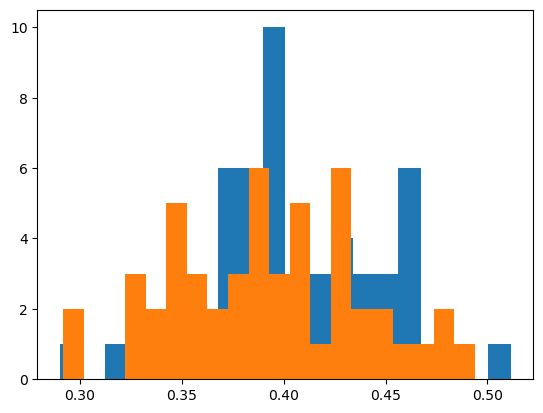

In [ ]:
# n, bins, _ = plt.hist(cor_scores, bins=20)
# mu = np.mean(cor_scores)
# sigma = np.std(cor_scores)
# print(f'{mu:.3f} +- {sigma:.3f}')
# n, bins, _ = plt.hist(prec_scores, bins=20)
# mu = np.mean(prec_scores)
# sigma = np.std(prec_scores)
# print(f'{mu:.3f} +- {sigma:.3f}')

In [ ]:
ttest_rel(cor_scores, prec_scores)

TtestResult(statistic=3.5637258011527617, pvalue=0.0008266584042734103, df=49)